# Get the original text data, import libs, and show some samples

In [1]:
!wget https://huggingface.co/datasets/bezirganyan/LUMA/resolve/main/text_data.tsv

--2024-11-27 20:46:17--  https://huggingface.co/datasets/bezirganyan/LUMA/resolve/main/text_data.tsv
Resolving huggingface.co (huggingface.co)... 3.171.171.128, 3.171.171.104, 3.171.171.65, ...
Connecting to huggingface.co (huggingface.co)|3.171.171.128|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs-us-1.hf.co/repos/91/6d/916d91190e01032d29384546038721047bf54420deab1052a661200d4b695d3d/34fdb88e6c762deda6bc625f7eb51394a584ff9306a9d7753ab223859754e42a?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27text_data.tsv%3B+filename%3D%22text_data.tsv%22%3B&response-content-type=text%2Ftab-separated-values&Expires=1732999577&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTczMjk5OTU3N319LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy11cy0xLmhmLmNvL3JlcG9zLzkxLzZkLzkxNmQ5MTE5MGUwMTAzMmQyOTM4NDU0NjAzODcyMTA0N2JmNTQ0MjBkZWFiMTA1MmE2NjEyMDBkNGI2OTVkM2QvMzRmZGI4OGU2Yzc2MmRlZGE2YmM2MjVmN2ViNTEzOTRhNTg0ZmY5MzA2Y

In [2]:
import pandas as pd
import random
import os
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from transformers import pipeline
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
import torch
from torch.utils.data import Dataset, DataLoader

In [3]:
data = pd.read_csv('text_data.tsv', sep='\t')

In [4]:
print(f'lenght of data: {len(data)}')

lenght of data: 62875


In [5]:
idx = random.randint(0, len(data))
print(f'sample {idx} \nText: {data.loc[idx].text} \nLabel: {data.loc[idx].label}')

sample 50458 
Text: **Chorus:**
Wolf, wolf, roamin' free,
Power and grace, eternally.
In the wild, where dreams take flight,
You embody strength, day and night.

**Verse:**
How your eyes flash with amber glow,
A symphony of moonlight and snow.
Your howl echoes through the night,
A call of the wild, a haunting might.

**Bridge:**
Through the forest you fiercely stride,
Your instinct guides you, never hide.
A predator of strength,
Defending your territory, a force of length.

**Chorus:**
Wolf, wolf, roamin' free,
Power and grace, eternally.
In the wild, where dreams take flight,
You embody strength, day and night.

**Outro:**
As the wind whips through your fur,
You leap and bound, forever pure.
Wolf, wolf, king of the wild,
Your spirit roams, eternally untied. 
Label: wolf


# Testing some models

We first filter the biases from non biased

## Binary classifier

based on the bias-detection-model model

### Inference

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("d4data/bias-detection-model")
model = TFAutoModelForSequenceClassification.from_pretrained("d4data/bias-detection-model")

classifier = pipeline('text-classification', model=model, tokenizer=tokenizer, device=0) # cuda = 0,1 based on gpu availability

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/657 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tf_model.h5:   0%|          | 0.00/268M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFDistilBertForSequenceClassification.

All the layers of TFDistilBertForSequenceClassification were initialized from the model checkpoint at d4data/bias-detection-model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


In [ ]:
# test on one sample
output = classifier(data.loc[idx].text)
output[0]

In [ ]:
data['text_length'] = data['text'].str.len()
data_sorted = data.sort_values(by='text_length')

In [ ]:
class TextDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe
    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        text = self.data.iloc[index]['text']
        return {
            'text': text,
        }

# Example usage
BATCH_SIZE = 32 # Adjust as needed

dataset = TextDataset(data_sorted)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
# Batching the input
i = 0
results = []
for batch in tqdm(dataloader):
    i += 1
    try:
        batch_results = classifier(batch['text'])
        results.extend(batch_results)
    except Exception as e:
        print(f"Error processing batch {i}: {e}")

  0%|          | 0/1965 [00:00<?, ?it/s]

In [ ]:
data_sorted['results'] = results
data_sorted.to_csv('binary_classification_results.csv', index=False)

In [ ]:
data_sorted

,text,label,text_length,results
17416,A bottle of water vapor suspended in the air,cloud,44,"{'label': 'Non-biased', 'score': 0.67796951532..."
18020,"A fox is quick and sly, it's a cunning animal.",fox,46,"{'label': 'Non-biased', 'score': 0.59829854965..."
46835,Plain clothes are comfortable to wear all day.,plain,46,"{'label': 'Biased', 'score': 0.6522274017333984}"
48252,We often gather around the table to eat and chat.,table,49,"{'label': 'Biased', 'score': 0.5837098956108093}"
4710,I'm planning on moving into a new house next m...,house,51,"{'label': 'Non-biased', 'score': 0.67790681123..."
...,...,...,...,...
17460,Clouds have traversed a storied path throughou...,cloud,1483,"{'label': 'Biased', 'score': 0.9771029949188232}"
19562,"Opuut: Castles, majestic structures steeped in...",castle,1486,"{'label': 'Biased', 'score': 0.9805306196212769}"
31717,"The frog, a beloved amphibian creature, has a ...",frog,1490,"{'label': 'Biased', 'score': 0.9920835494995117}"
17456,"Cloud, a wispy, ethereal aggregation, made of ...",cloud,1492,"{'label': 'Biased', 'score': 0.7810251712799072}"


## Some plots of the binary classifications

In [9]:
try:
    data_sorted = pd.read_csv('binary_classification_results.csv')
except Exception as e:
    print(e, '\ndata likely not found, run the inferece of the binary classification first')

[Errno 2] No such file or directory: 'binary_classification_results.csv' 
data likely not found, run the inferece of the binary classification first


In [8]:
data_sorted.head()

,text,label,text_length,results
0,A bottle of water vapor suspended in the air,cloud,44,"{'label': 'Non-biased', 'score': 0.67796951532..."
1,"A fox is quick and sly, it's a cunning animal.",fox,46,"{'label': 'Non-biased', 'score': 0.59829854965..."
2,Plain clothes are comfortable to wear all day.,plain,46,"{'label': 'Biased', 'score': 0.6522274017333984}"
3,We often gather around the table to eat and chat.,table,49,"{'label': 'Biased', 'score': 0.5837098956108093}"
4,I'm planning on moving into a new house next m...,house,51,"{'label': 'Non-biased', 'score': 0.67790681123..."


In [9]:
def get_bias_label(data, threshold = 0.9):
    # Extract label and score into separate columns
    data['bias_label'] = data['results'].apply(lambda x: 'Biased' if eval(x)['score'] > threshold else 'Non-biased')
    data['score'] = data['results'].apply(lambda x: eval(x)['score'])
    return data

In [10]:
data_sorted = get_bias_label(data_sorted, threshold = 0.98)

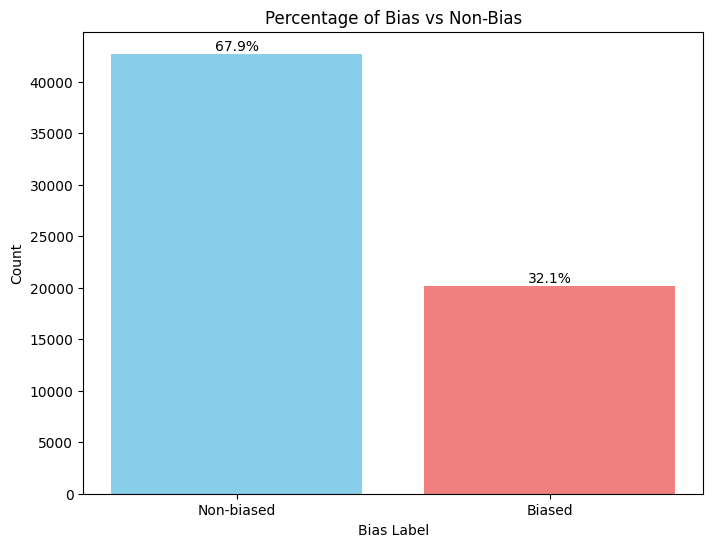

In [13]:
bias_counts = data_sorted['bias_label'].value_counts()

# Plotting
plt.figure(figsize=(8, 6))
bars = plt.bar(bias_counts.index, bias_counts.values, color=['skyblue', 'lightcoral'])

plt.xlabel('Bias Label')
plt.ylabel('Count')
plt.title('Percentage of Bias vs Non-Bias')

# Add percentage labels on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 5, f'{yval/len(data_sorted)*100:.1f}%', ha='center', va='bottom')


plt.show()

<ipython-input-20-2821f83fc134>:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  biased_cmap = cm.get_cmap('Reds')
<ipython-input-20-2821f83fc134>:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  non_biased_cmap = cm.get_cmap('Blues')


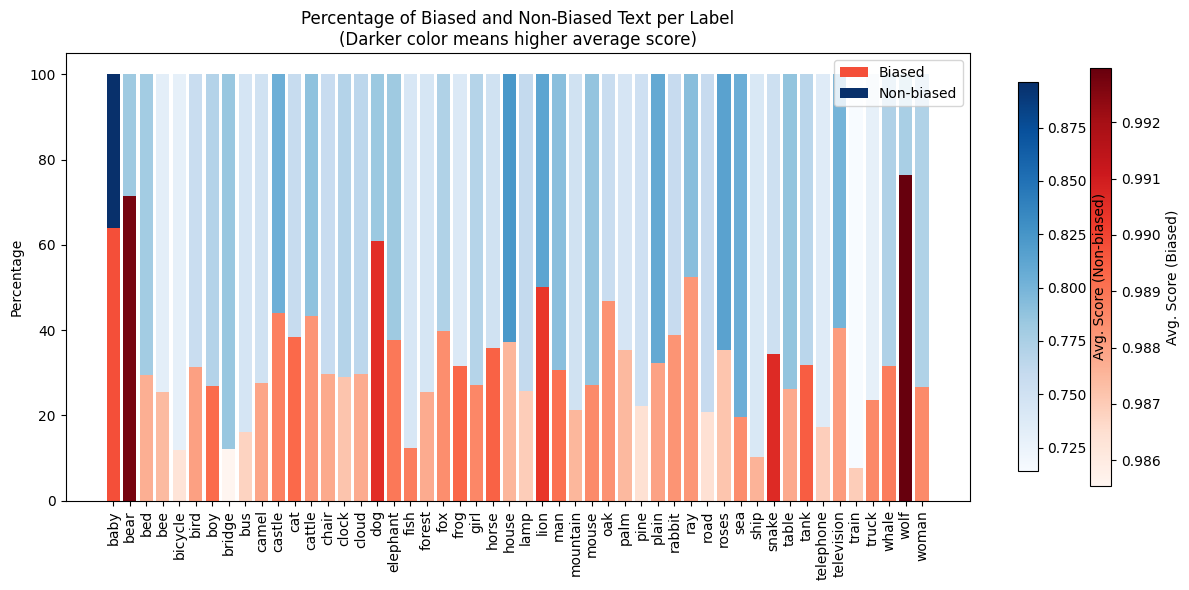

In [20]:
# Group data by label and bias_label to calculate percentages and average scores
label_bias_counts = data_sorted.groupby(['label', 'bias_label']).size().unstack(fill_value=0)
label_bias_percentages = label_bias_counts.div(label_bias_counts.sum(axis=1), axis=0) * 100
label_bias_scores = data_sorted.groupby(['label', 'bias_label'])['score'].mean().unstack(fill_value=0)

# Plotting
fig, ax = plt.subplots(figsize=(12, 6))  # Adjust figure size as needed

labels = label_bias_percentages.index
width = 0.8  # Width of each bar

# Define colormaps for "Biased" and "Non-biased"
biased_cmap = cm.get_cmap('Reds')
non_biased_cmap = cm.get_cmap('Blues')

# Normalize scores for color mapping
biased_norm = mcolors.Normalize(vmin=label_bias_scores['Biased'].min(), vmax=label_bias_scores['Biased'].max())
non_biased_norm = mcolors.Normalize(vmin=label_bias_scores['Non-biased'].min(), vmax=label_bias_scores['Non-biased'].max())

# Loop through labels to create stacked bars with color intensity based on average score
for i, label in enumerate(labels):
    bias_percentage = label_bias_percentages.loc[label, 'Biased']
    non_bias_percentage = label_bias_percentages.loc[label, 'Non-biased']

    # Average scores
    bias_score = label_bias_scores.loc[label, 'Biased']
    non_bias_score = label_bias_scores.loc[label, 'Non-biased']

    # Determine colors based on average scores
    bias_color = biased_cmap(biased_norm(bias_score))
    non_bias_color = non_biased_cmap(non_biased_norm(non_bias_score))

    # Stacked bars
    ax.bar(i, bias_percentage, width, color=bias_color, label='Biased' if i == 0 else "")
    ax.bar(i, non_bias_percentage, width, bottom=bias_percentage, color=non_bias_color, label='Non-biased' if i == 0 else "")

# Set x-ticks and labels
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels, rotation=90)
ax.set_ylabel('Percentage')
ax.set_title('Percentage of Biased and Non-Biased Text per Label\n(Darker color means higher average score)')
ax.legend()

# Add colorbars to explain color intensity
sm_biased = cm.ScalarMappable(cmap=biased_cmap, norm=biased_norm)
sm_non_biased = cm.ScalarMappable(cmap=non_biased_cmap, norm=non_biased_norm)
sm_biased.set_array([])
sm_non_biased.set_array([])

cbar_biased = plt.colorbar(sm_biased, ax=ax, fraction=0.02, label='Avg. Score (Biased)')
cbar_non_biased = plt.colorbar(sm_non_biased, ax=ax, fraction=0.02, label='Avg. Score (Non-biased)')

plt.tight_layout()
plt.show()

## Multiclass classification

### Multi-class classification of the positive samples

Let's go a little bit further

In [30]:
# Filter the DataFrame to keep only rows where 'bias_label' is 'Biased'
biased_data = data_sorted[data_sorted['bias_label'] == 'Biased']

# Now 'biased_data' contains only the rows where the bias label is True
biased_data.head()

,text,label,text_length,results,bias_label,score
7,"Lives in ponds, has a bouncy jump, likes to ea...",frog,54,"{'label': 'Biased', 'score': 0.9894745349884033}",Biased,0.989475
13,A rancher in Montana said his prized cattle we...,cattle,56,"{'label': 'Biased', 'score': 0.9950697422027588}",Biased,0.995070
36,It is a pleasure to sit in this chair and addr...,chair,61,"{'label': 'Biased', 'score': 0.9840436577796936}",Biased,0.984044
39,A young man sleeping in the bed was startled b...,bed,61,"{'label': 'Biased', 'score': 0.9888231754302979}",Biased,0.988823
93,**We must ensure that the well-being of all ba...,baby,67,"{'label': 'Biased', 'score': 0.9860105514526367}",Biased,0.986011


In [31]:
len(biased_data)

20170

In [22]:
# Use a pipeline as a high-level helper
pipe = pipeline("text-classification", model="PriyaPatel/bias_identificaiton45", device=0)

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at PriyaPatel/bias_identificaiton45.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


In [32]:
idx = random.randint(0, len(biased_data))
print(f'sample {idx} \nText: {biased_data.loc[idx].text} \nLabel: {biased_data.loc[idx].label}')

sample 17849 
Text: The young girl, a pupil at the academy, has a vivid imagination that often takes her to fantastical worlds. Through her creative writing, she brings those worlds to life. 
Label: girl


In [33]:
pipe(biased_data.loc[idx].text, )

[{'label': 'LABEL_9', 'score': 0.8749385476112366}]

In [43]:
class TextDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe
    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        text = self.data.iloc[index]['text']
        return {
            'text': text,
        }

# Example usage
BATCH_SIZE = 32 # Adjust as needed

dataset = TextDataset(biased_data)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)

In [46]:
# Batching the input
i = 0
results = []
for batch in tqdm(dataloader):
    i += 1
    try:
        batch_results = pipe(batch['text'])
        results.extend(batch_results)
    except Exception as e:
        print(f"Error processing batch {i}: {e}")

  0%|          | 0/631 [00:00<?, ?it/s]

In [47]:
biased_data['multiclass_bias'] = results
biased_data.to_csv('multiclass_bias.csv', index=False)

<ipython-input-47-740711cb7a2f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  biased_data['multiclass_bias'] = results


In [48]:
biased_data

,text,label,text_length,results,bias_label,score,multiclass_bias
7,"Lives in ponds, has a bouncy jump, likes to ea...",frog,54,"{'label': 'Biased', 'score': 0.9894745349884033}",Biased,0.989475,"{'label': 'LABEL_0', 'score': 0.9363294243812561}"
13,A rancher in Montana said his prized cattle we...,cattle,56,"{'label': 'Biased', 'score': 0.9950697422027588}",Biased,0.995070,"{'label': 'LABEL_9', 'score': 0.5395113825798035}"
36,It is a pleasure to sit in this chair and addr...,chair,61,"{'label': 'Biased', 'score': 0.9840436577796936}",Biased,0.984044,"{'label': 'LABEL_9', 'score': 0.9729388952255249}"
39,A young man sleeping in the bed was startled b...,bed,61,"{'label': 'Biased', 'score': 0.9888231754302979}",Biased,0.988823,"{'label': 'LABEL_2', 'score': 0.9616361856460571}"
93,**We must ensure that the well-being of all ba...,baby,67,"{'label': 'Biased', 'score': 0.9860105514526367}",Biased,0.986011,"{'label': 'LABEL_2', 'score': 0.99293452501297}"
...,...,...,...,...,...,...,...
62865,"Cattle, an enigmatic creature of immense econo...",cattle,1472,"{'label': 'Biased', 'score': 0.9867205619812012}",Biased,0.986721,"{'label': 'LABEL_0', 'score': 0.601341724395752}"
62866,"Castle, a formidable structure steeped in hist...",castle,1477,"{'label': 'Biased', 'score': 0.982559084892273}",Biased,0.982559,"{'label': 'LABEL_0', 'score': 0.8687813878059387}"
62867,"The bridge, a testament to human ingenuity and...",bridge,1480,"{'label': 'Biased', 'score': 0.9885673522949219}",Biased,0.988567,"{'label': 'LABEL_9', 'score': 0.8197706937789917}"
62871,"Opuut: Castles, majestic structures steeped in...",castle,1486,"{'label': 'Biased', 'score': 0.9805306196212769}",Biased,0.980531,"{'label': 'LABEL_0', 'score': 0.5889154076576233}"


## Some plots of the multiclass classification

In [11]:
try:
    data = pd.read_csv('multiclass_bias.csv')
except Exception as e:
    print(e, '\ndata likely not found, run the inferece of the binary classification first')

In [12]:
id2label = {'LABEL_0': 'Race/Color',
 'LABEL_1': 'Socioeconomic Status',
 'LABEL_2': 'Gender',
 'LABEL_3': 'Disability',
 'LABEL_4': 'Nationality',
 'LABEL_5': 'Sexual Orientation',
 'LABEL_6': 'Physical Appearance',
 'LABEL_7': 'Religion',
 'LABEL_8': 'Age',
 'LABEL_9': 'Profession'}

In [21]:
data.iloc[0].text, data.iloc[0].label

('Lives in ponds, has a bouncy jump, likes to eat flies.', 'frog')

In [23]:
id2label[eval(data.iloc[0].multiclass_bias)['label']],eval(data.iloc[0].multiclass_bias)['score']

('Race/Color', 0.9363294243812561)

In [38]:
data['bias_label_multiclass'] = data['multiclass_bias'].apply(lambda x: id2label[eval(x)['label']])

In [36]:
data

,text,label,text_length,results,bias_label,score,multiclass_bias,bias_label_multiclass
0,"Lives in ponds, has a bouncy jump, likes to ea...",frog,54,"{'label': 'Biased', 'score': 0.9894745349884033}",Biased,0.989475,"{'label': 'LABEL_0', 'score': 0.9363294243812561}",Race/Color
1,A rancher in Montana said his prized cattle we...,cattle,56,"{'label': 'Biased', 'score': 0.9950697422027588}",Biased,0.995070,"{'label': 'LABEL_9', 'score': 0.5395113825798035}",Profession
2,It is a pleasure to sit in this chair and addr...,chair,61,"{'label': 'Biased', 'score': 0.9840436577796936}",Biased,0.984044,"{'label': 'LABEL_9', 'score': 0.9729388952255249}",Profession
3,A young man sleeping in the bed was startled b...,bed,61,"{'label': 'Biased', 'score': 0.9888231754302979}",Biased,0.988823,"{'label': 'LABEL_2', 'score': 0.9616361856460571}",Gender
4,**We must ensure that the well-being of all ba...,baby,67,"{'label': 'Biased', 'score': 0.9860105514526367}",Biased,0.986011,"{'label': 'LABEL_2', 'score': 0.99293452501297}",Gender
...,...,...,...,...,...,...,...,...
20165,"Cattle, an enigmatic creature of immense econo...",cattle,1472,"{'label': 'Biased', 'score': 0.9867205619812012}",Biased,0.986721,"{'label': 'LABEL_0', 'score': 0.601341724395752}",Race/Color
20166,"Castle, a formidable structure steeped in hist...",castle,1477,"{'label': 'Biased', 'score': 0.982559084892273}",Biased,0.982559,"{'label': 'LABEL_0', 'score': 0.8687813878059387}",Race/Color
20167,"The bridge, a testament to human ingenuity and...",bridge,1480,"{'label': 'Biased', 'score': 0.9885673522949219}",Biased,0.988567,"{'label': 'LABEL_9', 'score': 0.8197706937789917}",Profession
20168,"Opuut: Castles, majestic structures steeped in...",castle,1486,"{'label': 'Biased', 'score': 0.9805306196212769}",Biased,0.980531,"{'label': 'LABEL_0', 'score': 0.5889154076576233}",Race/Color


In [40]:
label_bias_counts = data.groupby(['bias_label_multiclass']).size()

Honestly it doesn't make any sense

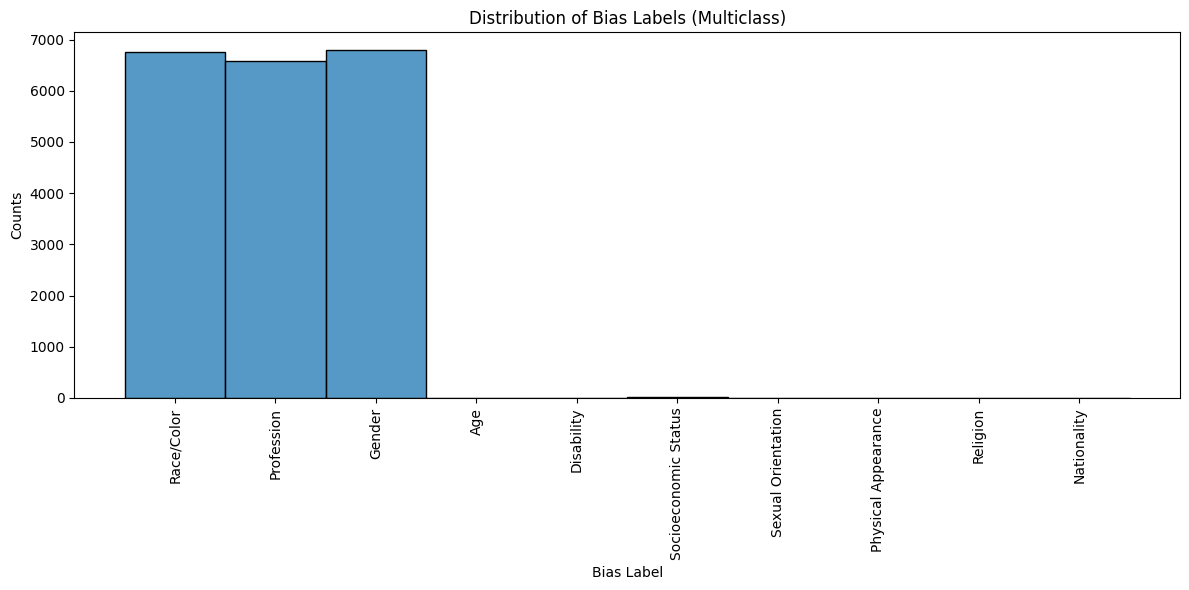

In [62]:
# Create the log distribution plot
plt.figure(figsize=(12, 6))
sns.histplot(data, x="bias_label_multiclass")  # Log scale on y-axis (counts)
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.xlabel("Bias Label")
plt.ylabel("Counts")
plt.title("Distribution of Bias Labels (Multiclass)")
plt.tight_layout()
plt.show()

In [61]:
# Filter the DataFrame based on bias_label_multiclass values in label_bias_counts <13
filtered_data = data[data['bias_label_multiclass'].isin(label_bias_counts[label_bias_counts < 13].index)]

# Now 'filtered_data' contains the rows where bias_label_multiclass is in the specified values
for i, row in filtered_data[['text', 'bias_label_multiclass']].iterrows():
  print(row.text, '\n:',row.bias_label_multiclass)
  print('\n==================')

A newborn baby in the NICU has been fighting for his life for the past 2 days. 
: Age

The bee is buzzing wildly,
A nectar thief, so sly,
Pollen spreading far and wide. 
: Disability

A flock of birds chirped incessantly as they soared above the emerald canopy of trees. 
: Socioeconomic Status

A five-month-old baby has begun teething, causing his parents to worry about his health. 
: Age

A furry friend that loves to play outside, has a wagging tail, and likes to chase balls. 
: Sexual Orientation

Young Prince Phillip, a bookworm, was captivated by the magical pages of "The Little Mermaid." 
: Socioeconomic Status

A weary man in a tavern sat with a book, reading about the Duke of Windsor's daring adventures. 
: Socioeconomic Status

Large, burly creatures that live on farms, produce milk, and sometimes pulled to pull heavy loads. 
: Physical Appearance

The weary man sat on the cold, stone throne, his mind wandering to distant lands and forgotten kings. 
: Socioeconomic Status

A yo

In [63]:
# Filter the DataFrame based on bias_label_multiclass values in label_bias_counts <13
other_data = data[data['bias_label_multiclass'].isin(label_bias_counts[label_bias_counts > 13].index)]

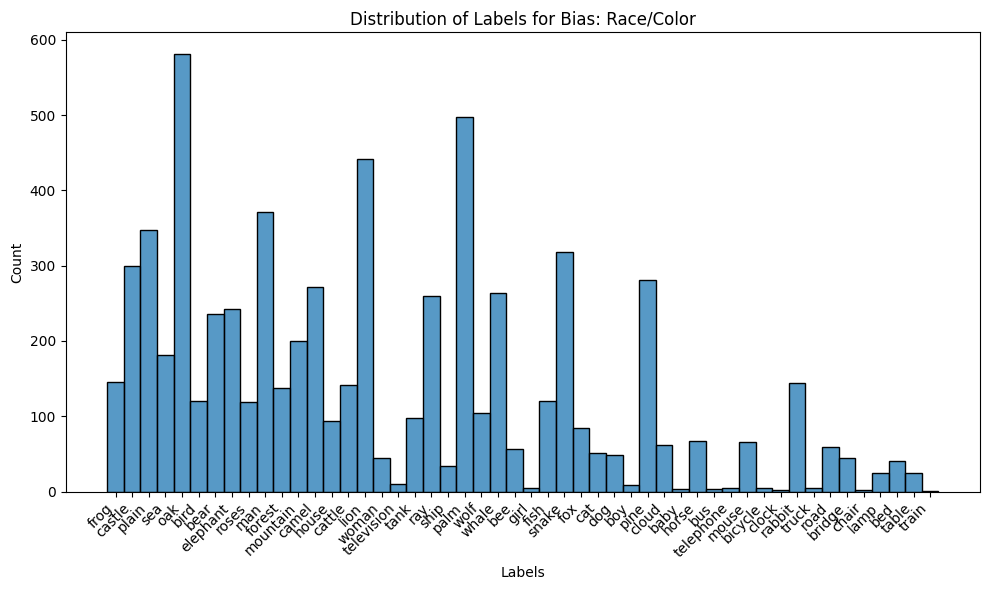

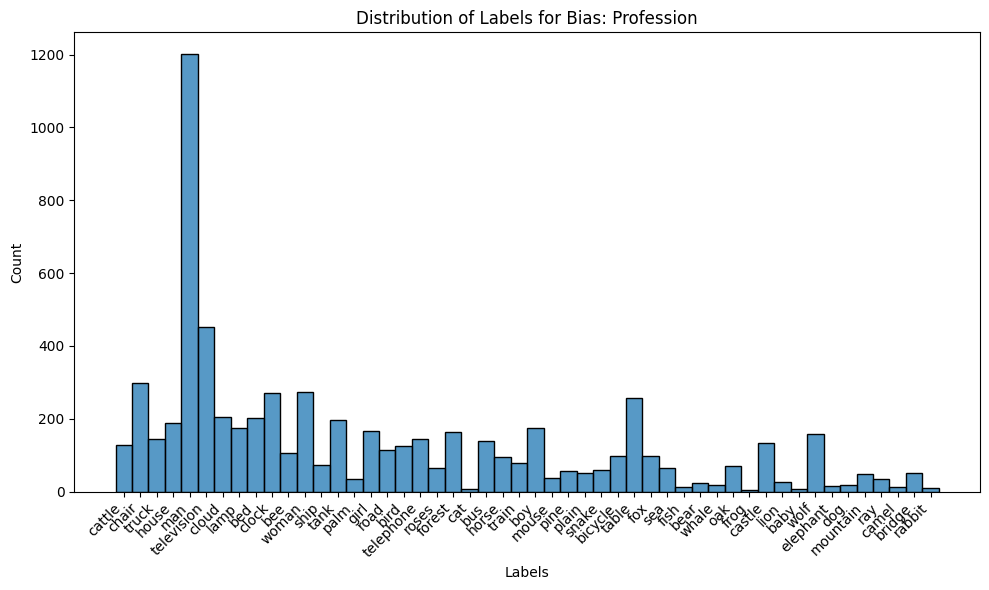

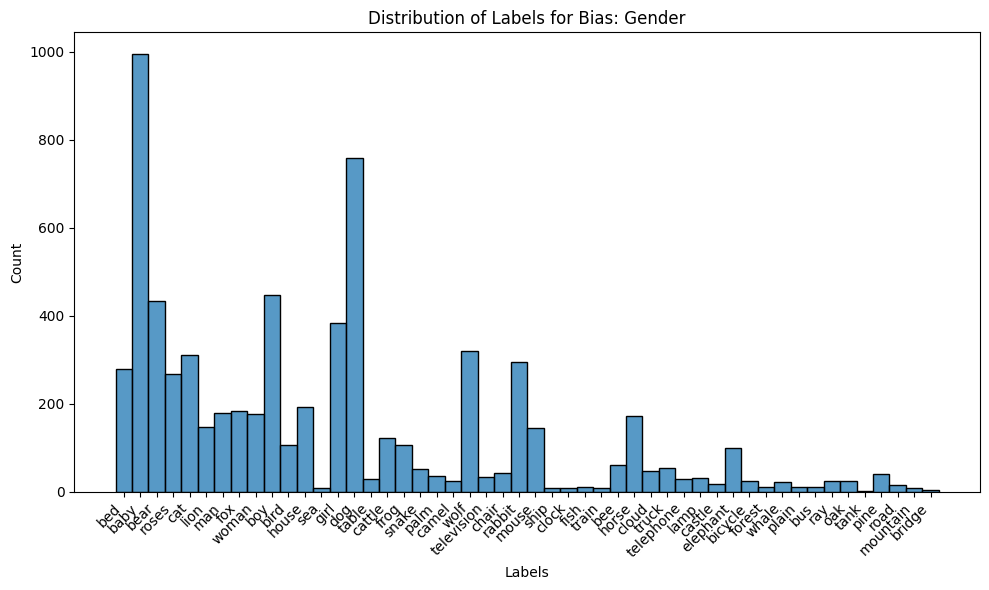

In [69]:
# Assuming 'other_data' and 'label' columns exist in your DataFrame
for bias_label in other_data['bias_label_multiclass'].unique():
    subset = other_data[other_data['bias_label_multiclass'] == bias_label]
    plt.figure(figsize=(10, 6))
    sns.histplot(subset, x="label")  # Use 'label' column for x-axis
    plt.title(f"Distribution of Labels for Bias: {bias_label}")
    plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels if needed
    plt.xlabel("Labels")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()